# Calculating the estimated abs based on ATP values: 

Here, we look at the comparsion between absoprtion and precipitation, then use the mapping to create an estimated time series

***Figures S17*** and ***Figures 7***

In [13]:
import sys

script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\Trends')
import trends_functions as fu_trends
sys.path.append(script_path+'\\functions_backtrajectories')
import functions_backtrajectories as fu_backtraj

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import curve_fit
import uncertainties.unumpy as unp
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import mannkendall as mk
from datetime import datetime, timedelta
from matplotlib.patches import Polygon
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def fancy(ax, fontsize=20, spines=['top','bottom','left','right'], alpha=0.5):    
    for axis in spines:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        

    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    ax.grid(True, alpha=alpha)  
    
def thickax(ax, fontsize=12, linewidth=4):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
    plt.rc('axes', linewidth=linewidth)
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=12, width=4, pad=12, bottom=True, top=False, left=True, right=False)    

In [15]:
loadpath = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis'
savepath_plots = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

In [16]:
df_abs637 = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended',                   
                       filename='oldpsap_newpsap_maap',)
df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')
df_rain_abs637 = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)
df = df_rain_abs637.rename(columns={'tp_era5':'accumulated'})

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat


In [17]:
df.head(2)

,abs637,fraction_241,accumulated,RAINFALL
2002-03-08 14:00:00,0.238,1.0,6.328704,3.969907
2002-03-08 15:00:00,0.082,1.0,6.259259,3.277778


In [18]:
df = fu_trends.slice_df(df, start_datetime='2001-12-31') #'2006-05-05' fire
first_season = fu_trends.get_first_season(df)        
season_to_season_num = fu_trends.get_full_season_abb_years(start_year=2002, number_years=2024-2002, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

In [19]:
df = fu_trends.prepare_data(df, dict_season_num_to_season=season_num_to_season)

start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


In [20]:
df.head(2)

,abs637,fraction_241,accumulated,RAINFALL,date,timestamp,ordinal,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,0.238,1.0,6.328704,3.969907,2002-03-08,2002-03-08 14:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,0.082,1.0,6.259259,3.277778,2002-03-08,2002-03-08 15:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


In [21]:
ordinal_to_season_abb = dict(zip(df['ordinal'], df['season_abb']))
month_ordinal_to_season_abb = dict(zip(df['month_ordinal'], df['season_abb']))
season_ordinal_to_season_abb = dict(zip(df['season_ordinal'], df['season_abb']))
month_ordinal_to_timestamp = dict(zip(df['month_ordinal'], df['timestamp']))
ordinal_to_timestamp = dict(zip(df['ordinal'], df['timestamp']))

In [22]:
def produce_dict_precip_abs(df, startyear, endyear, season=None, title='', 
                            bins=None, threshold=0, show_plot=False):    
    if bins is None:
        bins = np.arange(0,20, 0.25)    
    if season is not None:
        title = str(season)
        df = df[df['season_abb'] == season].copy()
        
    df_year = fu_trends.slice_df(df, start_datetime=str(startyear)+'-01-01', end_datetime=str(endyear)+'-12-31')
    
    df_binned = fu_trends.bin_data(df_year, number_of_bins=bins)
    df_groupby = fu_trends.produce_groupby_averages(df_binned)
    df_groupby = df_groupby.copy()     
    
    df_groupby = df_groupby.loc[(df_groupby['count'] > threshold)]
    
    if show_plot == True:
        fig = fu_trends.errorbar_plot(df_groupby, title=title, ymax=.6)
    
    precip_to_abs = dict(zip(df_groupby['bin_centres'], df_groupby['median']))
    return precip_to_abs

In [23]:
precip_to_abs = produce_dict_precip_abs(df, startyear=2002, endyear=2024, season=None, title='',
                                        bins=np.arange(0,200,.5), threshold=250)

In [24]:
precip_to_abs_AHZ = produce_dict_precip_abs(df, startyear=2002, endyear=2024, 
                                            season='AHZ', bins=np.arange(0,200,.5))
precip_to_abs_SUM = produce_dict_precip_abs(df, startyear=2002, endyear=2024, 
                                            season='SUM', bins=np.arange(0,200,.5))
precip_to_abs_SBU = produce_dict_precip_abs(df, startyear=2002, endyear=2024, 
                                            season='SBU', bins=np.arange(0,200,.5))

In [25]:
df = fu_trends.slice_df(df, start_datetime='2001-12-31', end_datetime='2023-12-31')

In [26]:
df_ordinal_accumualted = df.groupby('ordinal').agg({'accumulated':'median', 'abs637':'median',}).reset_index() 
df_seasonal_accumualted = df.groupby('season_ordinal').agg({'accumulated':'median', 'abs637':'median', }).reset_index()
df_month_accumualted = df.groupby('month_ordinal').agg({'accumulated':'median', 'abs637':'median',}).reset_index()

In [27]:
df_seasonal_accumualted.head(5)
df_month_accumualted.head(5)

,month_ordinal,accumulated,abs637
0,3,4.925926,0.209
1,4,6.680556,0.397
2,5,4.697917,0.715
3,6,7.212963,0.204
4,7,7.166667,0.089


In [28]:
def find_closest_value(d, value):
    d = {v: k for k, v in d.items()}
    res_key, res_val = min(d.items(), key=lambda x: abs(value - x[1]))
    return res_key

In [29]:
df_ordinal_accumualted['season_abb'] = df_ordinal_accumualted['ordinal'].map(ordinal_to_season_abb)
df_month_accumualted['season_abb'] = df_month_accumualted['month_ordinal'].map(month_ordinal_to_season_abb)
df_seasonal_accumualted['season_abb'] = df_seasonal_accumualted['season_ordinal'].map(season_ordinal_to_season_abb)

In [30]:
def create_composite(df_seasonal_accumualted, precip_to_abs):
    for i, ATP in enumerate(df_month_accumualted['accumulated'].values):
        closest_in_dict = find_closest_value(precip_to_abs, value=float(ATP))    
        df_month_accumualted.loc[i, 'abs_dependent_on_precip'] = closest_in_dict
    return df_seasonal_accumualted

In [31]:
def create_composite_using_seasons(df_seasonal_accumualted, precip_to_abs_AHZ, precip_to_abs_SBU, precip_to_abs_SUM):
    for i, ATP in enumerate(df_seasonal_accumualted['accumulated'].values):
        if df_seasonal_accumualted.loc[i, 'season_abb'] == 'AHZ':
            closest_in_dict = find_closest_value(precip_to_abs_AHZ, value=float(ATP))    
            df_seasonal_accumualted.loc[i, 'abs_dependent_on_precip'] = closest_in_dict

        if df_seasonal_accumualted.loc[i, 'season_abb'] == 'SBU':
            closest_in_dict = find_closest_value(precip_to_abs_SBU, value=float(ATP))    
            df_seasonal_accumualted.loc[i, 'abs_dependent_on_precip'] = closest_in_dict

        if df_seasonal_accumualted.loc[i, 'season_abb'] == 'SUM':
            closest_in_dict = find_closest_value(precip_to_abs_SUM, value=float(ATP))    
            df_seasonal_accumualted.loc[i, 'abs_dependent_on_precip'] = closest_in_dict
    return df_seasonal_accumualted

In [32]:
df_ordinal_accumualted = create_composite_using_seasons(df_ordinal_accumualted, precip_to_abs_AHZ, precip_to_abs_SBU, precip_to_abs_SUM)

In [33]:
df_seasonal_accumualted = create_composite_using_seasons(df_seasonal_accumualted, precip_to_abs_AHZ, precip_to_abs_SBU, 
                                                         precip_to_abs_SUM)

In [34]:
df_month_accumualted = create_composite_using_seasons(df_month_accumualted, precip_to_abs_AHZ, precip_to_abs_SBU, 
                                                    precip_to_abs_SUM)

In [35]:
def sf(sf_num):
    sf = '{0:.'+str(sf_num)+'f}'
    return sf

def remove_spines(ax):
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    
def add_trend(df_time_accumulated, time_col, abs_col, ax, freq, linecolour='b', label=''):
    x = df_time_accumulated[time_col].values
    y = df_time_accumulated[abs_col].values

    #THEIL SEN SLOPE   
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)
    
    trend = theil_m
    #significant figures
    sfs = sf(4)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 

    ax.plot(x, Theil_slope, ls='--', lw=1, c=linecolour,
            label=str('TS: y = '+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept)))
    ax.fill_between(x, up_slope, lo_slope, alpha=0.15, color=linecolour)
    return trend

In [36]:
def create_trend(df_time_accumulated, time_col, freq=12, label='', ms=3):
    fig, ax1 = plt.subplots(figsize=(8,3))
    ax1.plot(df_time_accumulated['mid_datetime'], df_time_accumulated['abs637'], 'x', label='', c='k', ms=0, lw=0)    
    ax2 = ax1.twiny() #for trend i.e. integers
    ax2.set_xticks([]) #dont want these ticks
    
    abs_depedent = ax2.plot(df_time_accumulated[time_col], df_time_accumulated['abs_dependent_on_precip'], '-', marker='o', 
             label='depend. precip',
             ms=ms, mfc=None)  
    color = abs_depedent[0].get_color()

    ax2.plot(df_time_accumulated[time_col], df_time_accumulated['abs637'], '-', marker='o', 
             label='abs', c='k', ms=ms, mfc=None, mec='k')
    
    trend_abs_depedent = add_trend(df_time_accumulated=df_time_accumulated, time_col=time_col, 
                                   abs_col='abs_dependent_on_precip', label='dependent on precip',
                                   ax=ax2, freq=freq, linecolour=color)
    
    trend_abs = add_trend(df_time_accumulated=df_time_accumulated, time_col=time_col, 
                          abs_col='abs637', label='$\sigma_{\mathrm{ap}}$',
                          ax=ax2, freq=freq, linecolour='k')    
    
    print((trend_abs_depedent/trend_abs)*100)    
    for ax in [ax1, ax2]:
        remove_spines(ax)    
    plt.legend(frameon=False, loc=1, ncol=2, bbox_to_anchor=(1.1, 1.05))
    ax1.set_ylabel('$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]', fontsize=15)
    plt.show()
    return fig

In [37]:
def convert_season_add_year_to_datetime(season_abb_year):
    year = str(season_abb_year)[-4:]
    season_abb = str(season_abb_year)[:3] 
    if season_abb == 'AHZ':
        start = year+'-02-'+'01'
        stop = year+'-05-'+'31'
    if season_abb == 'SUM':
        start = year+'-06-'+'01'
        stop = year+'-09-'+'30'        
    if season_abb == 'SBU':
        start = year+'-10-'+'01'
        stop = str(int(year)+1)+'-01-'+'31'
    start = pd.to_datetime(start)
    stop = pd.to_datetime(stop)
    return start, stop

def mid_datetime_function(a, b):
    return a + (b - a)/2

def add_mid_datetime_using_dictionary(df, season_num_to_season):
    df['season_abb_year'] = df['season_ordinal'].map(season_num_to_season)
    df['start'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[0])
    df['stop'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[1])
    df['mid_datetime'] = df.apply(lambda x: mid_datetime_function(x.start, x.stop), axis=1)
    return df

In [38]:
df_seasonal_accumualted.head(2)

,season_ordinal,accumulated,abs637,season_abb,abs_dependent_on_precip
0,1,5.115741,0.399,AHZ,0.203
1,2,8.824074,0.105,SUM,0.034


In [39]:
df_seasonal_accumualted = add_mid_datetime_using_dictionary(df_seasonal_accumualted, season_num_to_season)

-0.0


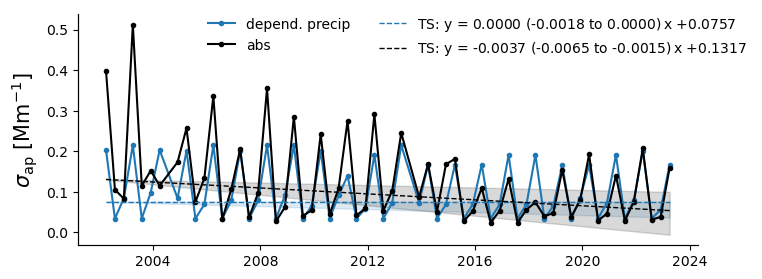

In [40]:
fig = create_trend(df_seasonal_accumualted, 'season_ordinal', freq=3)

In [41]:
df_month_accumualted['mid_datetime'] = df_month_accumualted['month_ordinal'].map(month_ordinal_to_timestamp)

-0.0


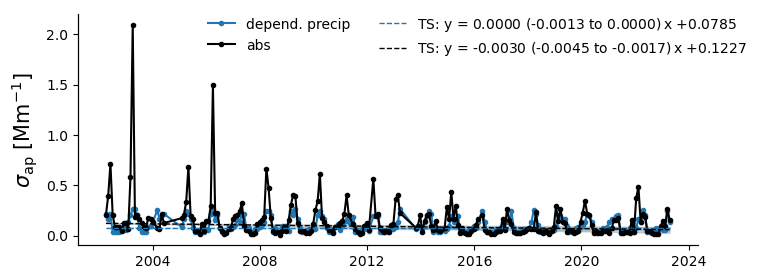

In [42]:
fig = create_trend(df_month_accumualted, 'month_ordinal', freq=12)

In [43]:
df_ordinal_accumualted['mid_datetime'] = df_ordinal_accumualted['ordinal'].map(ordinal_to_timestamp)

nan


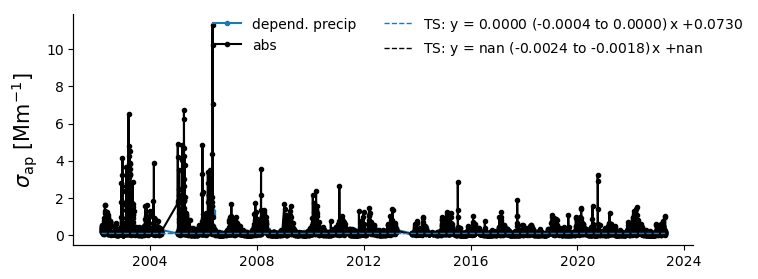

In [44]:
fig = create_trend(df_ordinal_accumualted, 'ordinal', freq=365)

In [45]:
df = df_ordinal_accumualted.set_index('mid_datetime')

In [46]:
df = fu_trends.prepare_data(df, season_num_to_season)

start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


In [47]:
df.head(2)

,ordinal,accumulated,abs637,season_abb,abs_dependent_on_precip,date,timestamp,day,month,year,year_num,month_ordinal,month_num,season_name,season_abb_year,season_ordinal
mid_datetime,,,,,,,,,,,,,,,,
2002-03-08 23:00:00,1,5.574074,0.220,AHZ,0.201,2002-03-08,2002-03-08 23:00:00,8,3,2002,1,3,3,Arctic Haze,AHZ_2002,1
2002-03-09 08:00:00,2,5.143519,0.205,AHZ,0.203,2002-03-09,2002-03-09 08:00:00,9,3,2002,1,3,3,Arctic Haze,AHZ_2002,1


# Compare prediction and observations: 

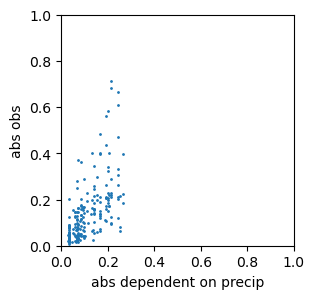

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(df_month_accumualted['abs_dependent_on_precip'], df_month_accumualted['abs637'],'o', ms=1)
plt.xlabel('abs dependent on precip')
plt.ylabel('abs obs')
plt.ylim(0, 1.)
plt.xlim(0,1.)
plt.show()

# Use clusters: 

Use the clusters to perform analysis: 
Generate a seasonal relationships for each 5 clusters

In [49]:
script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\clustering_HYSPLIT')

import clustering_functions as fu_cluster
from scipy.interpolate import interp1d

cluster_loadpath = r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered'

df_clusters = pd.read_pickle(cluster_loadpath+'\\df_clusters_5_v2.pickle')

df_value_count = fu_cluster.count_value_find_percentage(df_clusters)
df_max_count = fu_cluster.find_the_max_count(df_value_count)
df_max_count_abs637 = fu_cluster.merge_with_obs(df_max_count, df)

Length before: 6223
Length after: 6201
datetime64[ns]
datetime64[ns]
Length before: 107325
Length after: 107325
single index
datetime64[ns]
datetime64[ns]


In [50]:
def exp_function(x, a, b, c, d):
    return a * np.exp(b*x + c) + d

def add_fit_curve_function(exp_function, x, y, p0=[1,-2, 0, 0], maxfev=50000, ax=None):   
    popt, pcov = curve_fit(exp_function, x, y, p0=p0, maxfev=maxfev) # retrieve parameter values
    a = popt[0]
    b = popt[1]
    c = popt[2]
    d = popt[3]
    px = np.linspace(x.min(), x.max(), 100)
    py = a*unp.exp(b*px+c)+d
    nom = unp.nominal_values(py) # plot the regression
    ax.plot(px, nom, c='b', label=r'y='+str(np.round(a, 3))+' exp('+str(np.round(b, 3))+' x + '+str(np.round(c, 3))+') + '+str(np.round(d, 3)))
    return ax

def errorbar_plot(df_groupby, ymax, title='', idx=None, fontsize=15,
                  xlabel='Average accumulated precipiation en route\n of 10 day back trajectory [mm]',
                  xscale=None, xmax=None, ylabel='$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]',
                  y2_label='Number of data points in bins [-]', y2max=None,
                  annotate=None, slope_units='Mm$^{-1}$/mm', add_interpolate=False, show_legend=True, 
                  remove_y2_ticks=False, add_fit=False, function=exp_function, p0=[1,-2, 0], maxfev=50000, ax=None):                  
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))    

    df_groupby = df_groupby.set_index('bin_centres')
    df_groupby.index = df_groupby.index.astype(float) #if bins of 1 
    df_groupby = df_groupby[~df_groupby.isin([np.inf, -np.inf]).any(1)]
    index = df_groupby.index
    median = df_groupby['median']
    mean = df_groupby['mean']
    count = df_groupby['count']    
    quan_25 = df_groupby['q25'].values
    quan_75 = df_groupby['q75'].values
    
    error_label='25$^{\mathrm{th}}$ - 75$^{\mathrm{th}}$'
    ax.errorbar(index, median, yerr=[median-quan_25, quan_75-median], fmt='o', capsize=5, color='k', 
                mfc='None', ecolor='k', ms=1, label=error_label)
    ax.plot(index, median, label='median', marker='o', mec='k', mfc='none', c='k', ls='-')         
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)

    if xmax is not None:
        ax.set_xlim(0, xmax)

    if idx is not None:        
        slope, intercept = calculate_slope_intercept(index, median, idx)
        slope3sf = significant_figures(slope, 3)
        ax.plot(index[:idx], slope*index[:idx] + intercept, 
                label="slope: "+str(slope3sf)+str(slope_units),
                       c='r', lw=1)
    ax.set_title(title, loc='left')
    
    if add_interpolate == True:
        x = list(df_groupby.index)
        y = df_groupby['median'].values
        try:
            f = interp1d(x, y)
            xnew = np.linspace(x[0], x[-1], num=41, endpoint=True)
            ax.plot(xnew, f(xnew), marker='*',lw=0, label='linear inter.')
            interpolated_acc = xnew
            interpolated_obs = f(xnew)
        except:
            interpolated_acc = None
            interpolated_obs = None
            pass
        
    if show_legend == True:        
        ax.legend(frameon=False)
        
    ax.tick_params(axis='y', labelcolor='k', labelsize=15,which='major', direction='in', length=4, width=1.3, pad=10, 
                   bottom=False, top=False, left=True, right=False, color='k')
    ax.tick_params(axis='x', labelcolor='k', labelsize=15,which='major', direction='in', length=8, width=1.3, pad=10, 
                   bottom=False, top=False, left=True, right=False, color='k')                  
    if xscale=='log':
        ax.set_xscale('log')
        
    if add_fit == True:
        try:
            print("curve")
            add_fit_curve_function(function, index, median, p0=p0, maxfev=maxfev, ax=ax)
        except: 
            print("error")
            pass

    ax2 = ax.twinx()
    ax2.plot(index, count, label='count', marker='x', color='b', alpha=.2)
    ax2.set_ylabel(y2_label, fontsize=fontsize, rotation=270, labelpad=15, c='b')
    
    if remove_y2_ticks == True: 
        ax2.set_yticks([], [])
    
    if y2max is not None:
        ax2.set_ylim(0, y2max) #count

    if annotate is not None:
        count = count[count > 0]        
        ax2.annotate(count.iloc[annotate[0]], (count.index[annotate[0]],1), c='b')
        ax2.annotate(count.iloc[annotate[2]], (count.index[annotate[1]],1), c='b')
        ax2.annotate(count.iloc[annotate[2]], (count.index[annotate[2]],1), c='b')
    ax2.tick_params(axis='y', labelcolor='b', labelsize=15,which='major', direction='in', length=4, width=1.3, pad=10, 
               bottom=False, top=False, left=False, right=True, color='b')
    if ax is None:        
        plt.show()
    if add_interpolate==True:
        return ax, interpolated_acc, interpolated_obs
    if add_interpolate==False:
        return ax    

In [51]:
def produce_dict_precip_abs(df, startyear, endyear, season=None, cluster=None,
                            bins=None, threshold=0, title='', ymax=None, xmax=None,
                            add_interpolate=True, ax=None):    
    if bins is None:
        bins = np.arange(0,20, 0.25)    
    if season is not None:
        df = df[df['season_abb'] == season].copy()
        title="Season: "+str(season)
    if cluster is not None:
        title="Cluster: "+str(cluster)  
    if (cluster is not None) & (season is not None):
        title="Cluster: "+str(cluster)+" Season: "+str(season)  
    
    df_year = fu_trends.slice_df(df, start_datetime=str(startyear)+'-01-01', end_datetime=str(endyear)+'-12-31')    
    
    df_binned = fu_trends.bin_data(df_year, number_of_bins=bins)
    df_groupby = fu_trends.produce_groupby_averages(df_binned)
    df_groupby = df_groupby.copy()         
    df_groupby = df_groupby.loc[(df_groupby['count'] > threshold)]

    max_value = df_groupby[['mean','median', 'min', 'max', 'std', 'q25', 'q75']].max()
    
    if add_interpolate==False:
        ax = errorbar_plot(df_groupby, title=str(title), ymax=ymax, xmax=xmax, add_interpolate=add_interpolate, ax=ax)
        precip_to_abs = dict(zip(df_groupby['bin_centres'], df_groupby['median']))
        
    if add_interpolate==True:
        ax, interpolated_acc, interpolated_obs = errorbar_plot(df_groupby, title=str(title), ymax=ymax, 
                                                            xmax=xmax, add_interpolate=add_interpolate, ax=ax)
        precip_to_abs = dict(zip(interpolated_acc, interpolated_obs))  
       
    return precip_to_abs

In [52]:
dict_season_cluster_to_ymax = {'1_AHZ':0.3, '1_SUM':0.2, '1_SBU':0.2, 
                               '2_AHZ':0.5, '2_SUM':0.1, '2_SBU':0.2,
                              '3_AHZ':0.4, '3_SUM':0.15, '3_SBU':0.2,
                              '4_AHZ':0.4, '4_SUM':0.15,'4_SBU':0.2,
                              '5_AHZ':0.6, '5_SUM':0.21, '5_SBU':0.6}

In [53]:
def get_df_dict(df, number_of_plots, clusters=[1,2,3,4,5], seasons = ['AHZ', 'SUM', 'SBU'], startyear=2002,
                endyear=2023, threshold=5, bins=np.arange(0,50, 3)):
    DFs = []
    names = []
    for cluster in [1,2,3,4,5]:
        df_cluster = df[df['clusters_5'] == cluster].copy()
        for season in ['AHZ', 'SUM', 'SBU']:
            print(str(cluster)+str(season))
            df_cluster_season = df_cluster[df_cluster['season_abb'] == season].copy()
            DFs.append(df_cluster_season)
            names.append(str(cluster)+'_'+str(season))    
    dict_name_to_df = {}
    dict_name_to_len = {}
    for i in range(number_of_plots): 
        df = DFs[i] 
        df_year = fu_trends.slice_df(df, start_datetime=str(startyear)+'-01-01', end_datetime=str(endyear)+'-12-31')   
        df_binned = fu_trends.bin_data(df_year, number_of_bins=bins)
        df_groupby = fu_trends.produce_groupby_averages(df_binned)
        df_groupby = df_groupby.copy()         
        df_groupby = df_groupby.loc[(df_groupby['count'] > threshold)]
        max_value = df_groupby[['mean','median', 'min', 'max', 'std', 'q25', 'q75']].max()  
        name = names[i]
        dict_name_to_df[name] = df_groupby
        dict_name_to_len[name] = len(df)
    return dict_name_to_df, dict_name_to_len

In [54]:
def produce_dict_precip_abs(df, startyear=2002, endyear=2023, season=None, cluster=None,
                            bins=None, threshold=0, title='', ymax=None, xmax=None,
                            add_interpolate=True):    
    if bins is None:
        bins = np.arange(0,20, 0.25)    
    if season is not None:
        df = df[df['season_abb'] == season].copy()
        title="Season: "+str(season)
    if cluster is not None:
        title="Cluster: "+str(cluster)  
    if (cluster is not None) & (season is not None):
        title="Cluster: "+str(cluster)+" Season: "+str(season)  
    
    df_year = fu_trends.slice_df(df, start_datetime=str(startyear)+'-01-01', end_datetime=str(endyear)+'-12-31')    
    
    df_binned = fu_trends.bin_data(df_year, number_of_bins=bins)
    df_groupby = fu_trends.produce_groupby_averages(df_binned)
    df_groupby = df_groupby.copy()         
    df_groupby = df_groupby.loc[(df_groupby['count'] > threshold)]

    max_value = df_groupby[['mean','median', 'min', 'max', 'std', 'q25', 'q75']].max()
    
    if add_interpolate==False:
        ax = errorbar_plot(df_groupby, title=str(title), ymax=ymax, xmax=xmax, add_interpolate=add_interpolate)
        precip_to_abs = dict(zip(df_groupby['bin_centres'], df_groupby['median']))
        
    if add_interpolate==True:
        ax, interpolated_acc, interpolated_obs = errorbar_plot(df_groupby, title=str(title), ymax=ymax, 
                                                            xmax=xmax, add_interpolate=add_interpolate)
        precip_to_abs = dict(zip(interpolated_acc, interpolated_obs))  
       
    return precip_to_abs

In [55]:
def dict_precip_to_abs_clusters_seasons(df, bins, threshold):
    dict_precip_to_abs = {}
    for cluster in [1,2,3,4,5]:
        df_cluster = df[df['clusters_5'] == cluster].copy()
        for season in ['AHZ', 'SUM', 'SBU']:
            try:
                precip_to_abs = produce_dict_precip_abs(df_cluster, bins=bins, threshold=threshold,
                                                        cluster=cluster, season=season,
                                                        ymax=1.1, xmax=25, add_interpolate=True)
                plt.show()
                dict_precip_to_abs['cluster_'+str(cluster)+'_'+str(season)] = precip_to_abs
            except:
                pass
    return dict_precip_to_abs

## produce the dictionaries from precipiation to abs which can then be used to map the ATP values: 

1AHZ
1SUM
1SBU
2AHZ
2SUM
2SBU
3AHZ
3SUM
3SBU
4AHZ
4SUM
4SBU
5AHZ
5SUM
5SBU


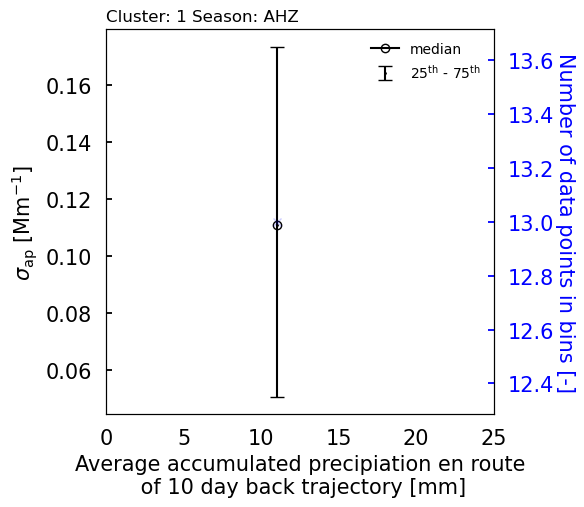

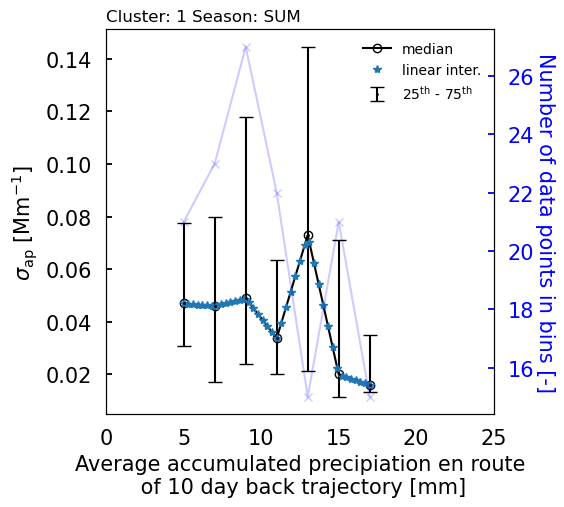

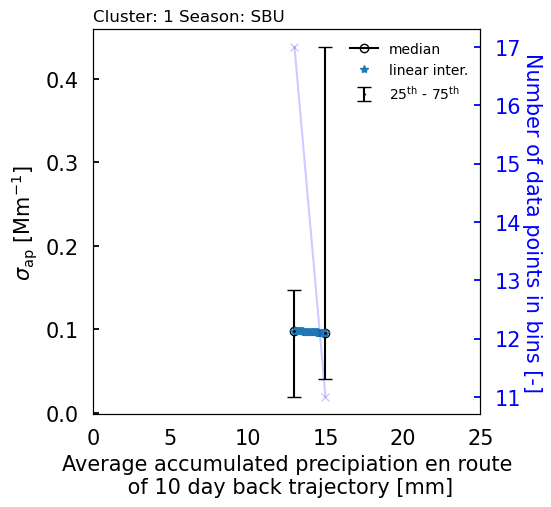

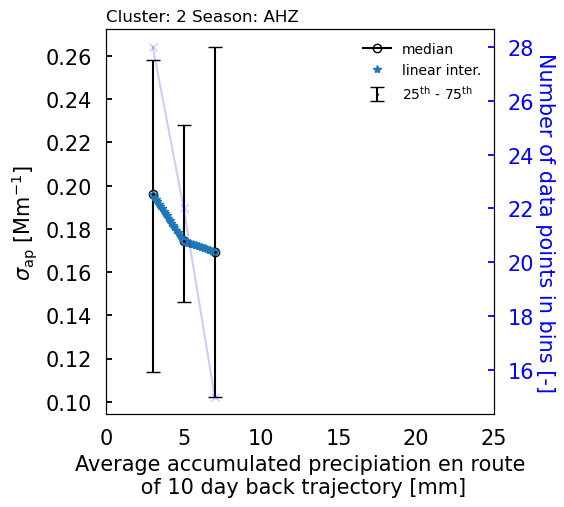

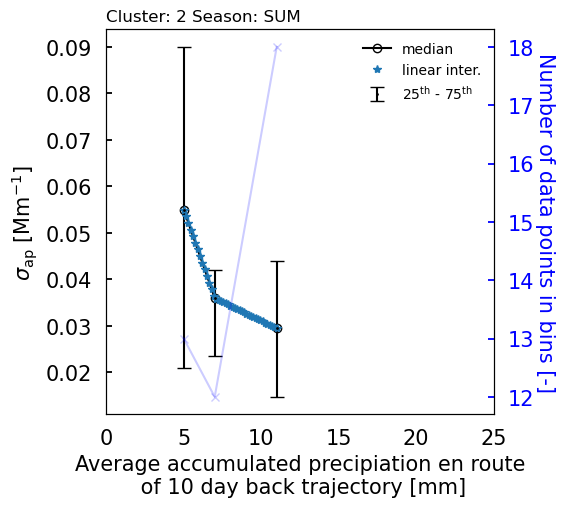

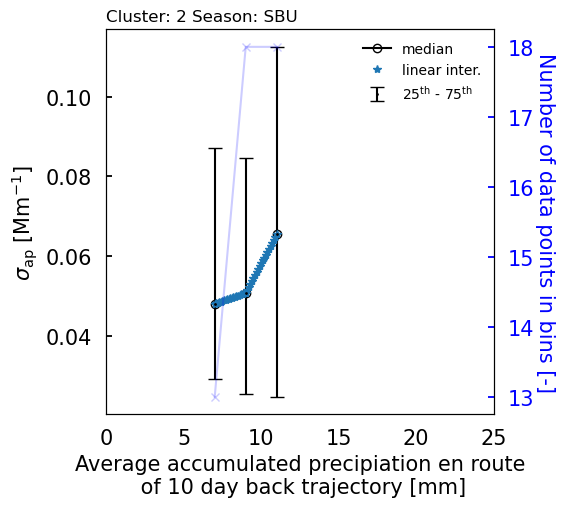

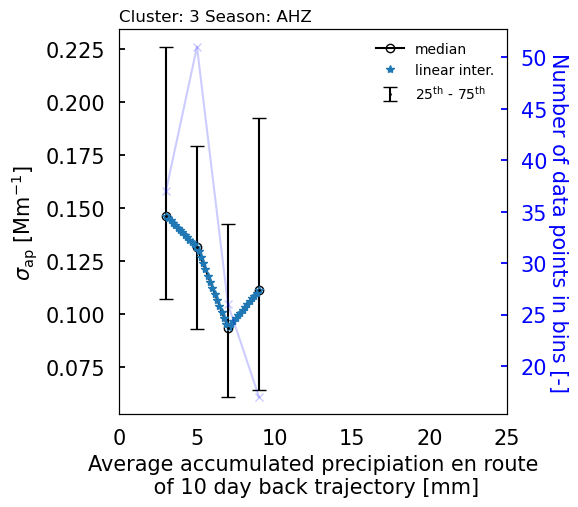

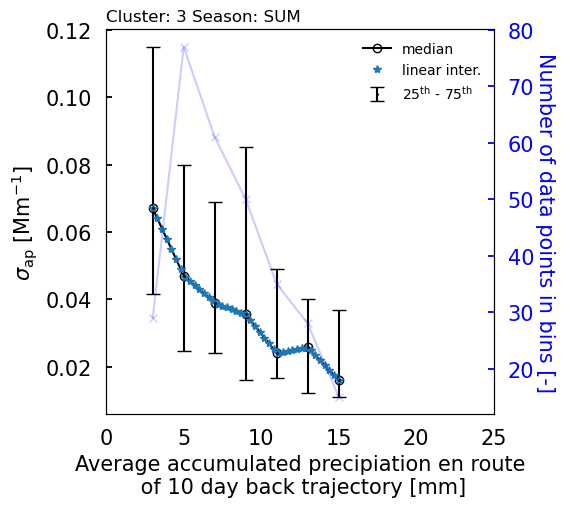

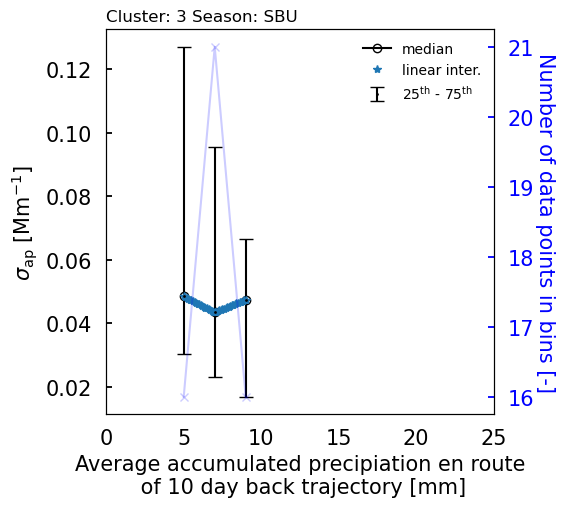

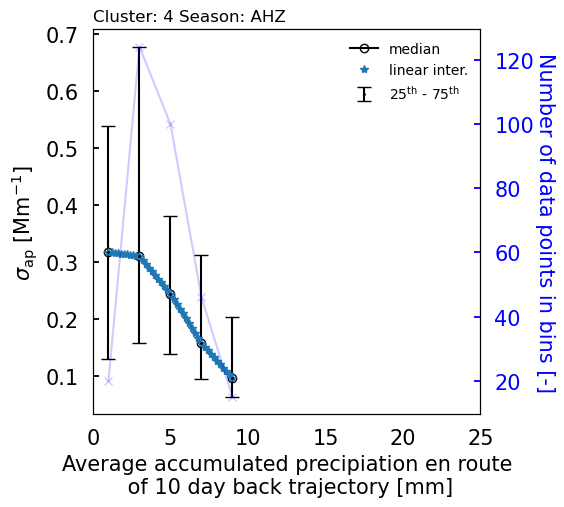

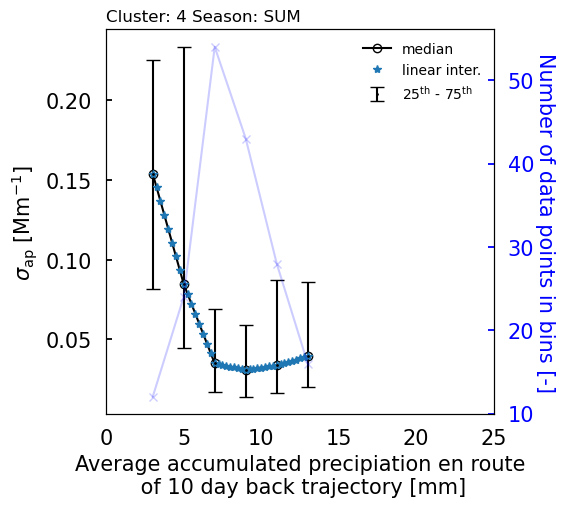

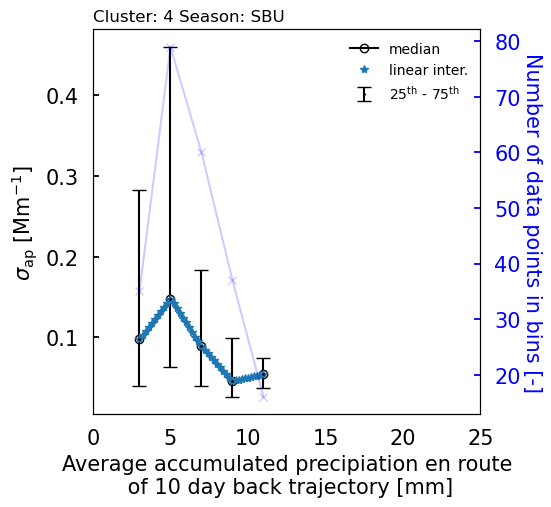

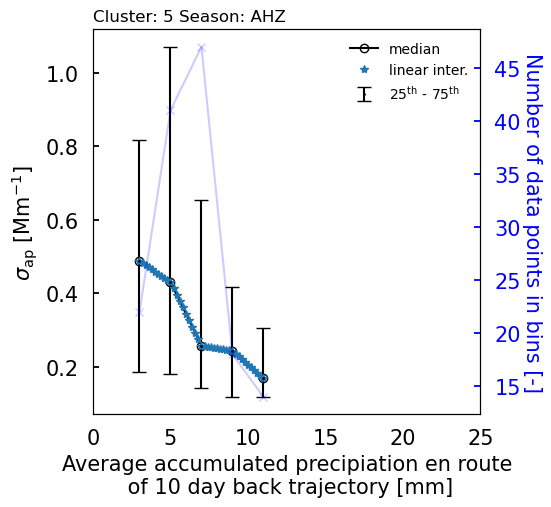

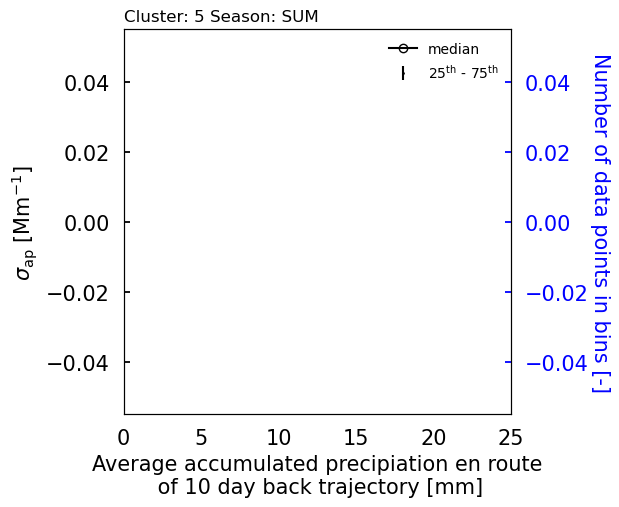

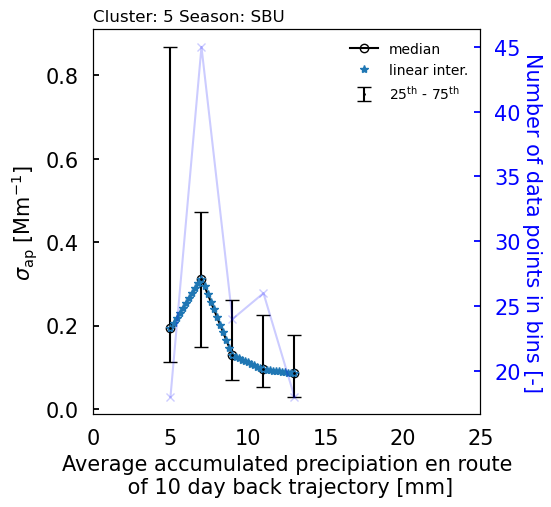

In [56]:
df = df_max_count_abs637.sample(frac=.5)
threshold=10
bins=np.arange(0,50, 2)
clusters = [1,2,3,4,5]
seasons = ['AHZ', 'SUM', 'SBU']
fontsize=20
fs_ticks=12
number_of_plots = len(clusters)*len(seasons)
nrows=len(clusters); ncols=len(seasons)

dict_name_to_df, dict_name_to_len = get_df_dict(df, number_of_plots, threshold=threshold, bins=bins)
dict_precip_to_abs = dict_precip_to_abs_clusters_seasons(df, threshold=threshold, bins=bins)

# Figure S17: 

curve
error
curve
curve
error
curve
error
curve
error
curve
error
curve
curve


C:\Users\DominicHeslinRees\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


curve
error
curve
curve
curve
curve
curve
error
curve


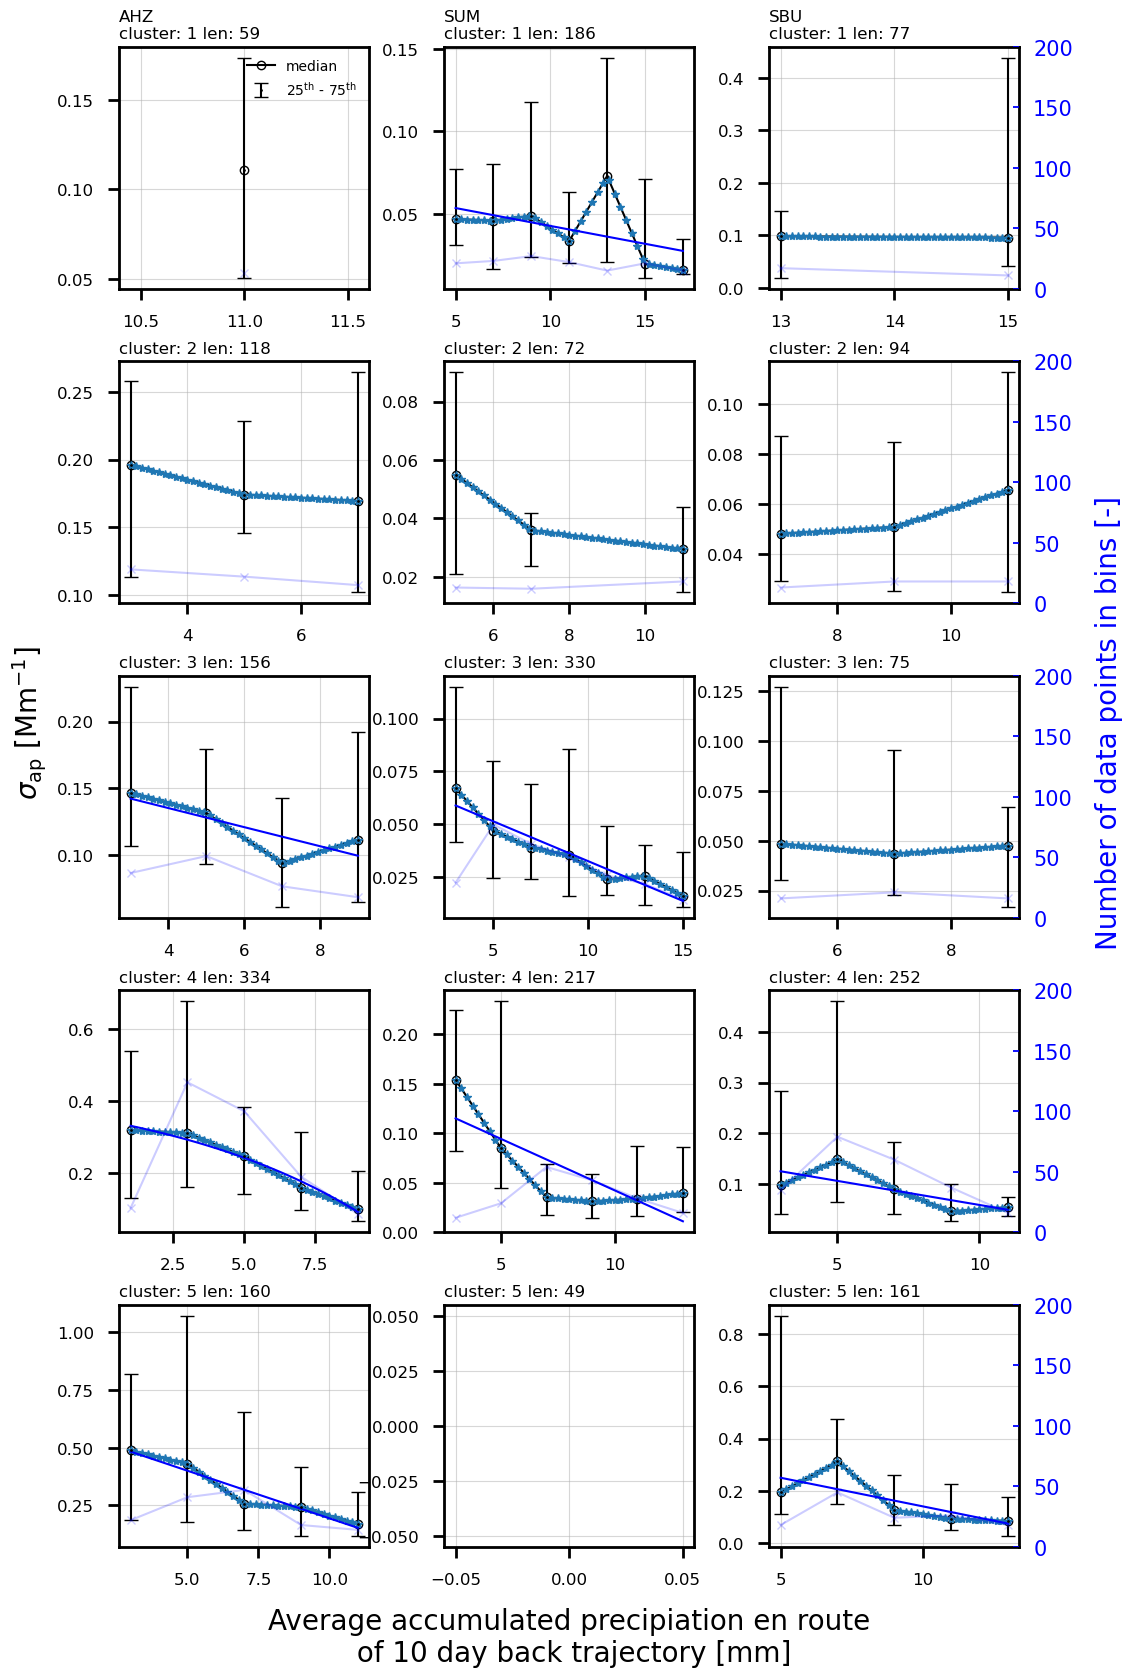

In [57]:
fig = plt.figure(figsize=(ncols*3,nrows*3))

#nrows, ncols
gs = gridspec.GridSpec(nrows, ncols, hspace = 0.3, wspace = 0.3, top = 1,
                       bottom = 0, left = 0, right = 1)
#row, col
###cluster 1
cluster_season = '1_AHZ'
ax = fig.add_subplot(gs[0, 0])
df_groupby = dict_name_to_df[cluster_season]
title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], 
              xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=True, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)   
fancy(ax, fs_ticks)

ax = fig.add_subplot(gs[0, 1])
cluster_season = '1_SUM'
df_groupby = dict_name_to_df[cluster_season]
title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, 
              remove_y2_ticks=True, y2max=200, p0=[0, 0, 0, 0], 
              maxfev=50000, ax=ax) 
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[0, 2])
cluster_season = '1_SBU'
df_groupby = dict_name_to_df[cluster_season]
title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['1_SBU'], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, y2max=200, p0=[0, 0, 0, 0], 
              maxfev=50000, ax=ax)  
fancy(ax, fs_ticks)

###cluster 2
ax = fig.add_subplot(gs[1, 0])
cluster_season = '2_AHZ'
df_groupby = dict_name_to_df['2_AHZ']
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_AHZ'], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[1, 1])
cluster_season = '2_SUM'
df_groupby = dict_name_to_df['2_SUM']
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_SUM'], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[1, 2])
cluster_season = '2_SBU'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_SBU'], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, y2max=200, ax=ax)  
fancy(ax, fs_ticks)


###cluster 3
ax = fig.add_subplot(gs[2, 0])
cluster_season = '3_AHZ'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200,  ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[2, 1])
cluster_season = '3_SUM'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200,  ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[2, 2])
cluster_season = '3_SBU'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, y2max=200, ax=ax)  
fancy(ax, fs_ticks)

###cluster 4
ax = fig.add_subplot(gs[3, 0])
cluster_season = '4_AHZ'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[3, 1])
cluster_season = '4_SUM'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[3, 2])
cluster_season = '4_SBU'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, y2max=200, ax=ax)  
fancy(ax, fs_ticks)

###cluster 5
ax = fig.add_subplot(gs[4, 0])
cluster_season = '5_AHZ'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[4, 1])
cluster_season = '5_SUM'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
fancy(ax, fs_ticks)
ax = fig.add_subplot(gs[4, 2])
cluster_season = '5_SBU'
df_groupby = dict_name_to_df[cluster_season]
title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
              y2_label='', add_interpolate=True, show_legend=False, 
              add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
              maxfev=50000, y2max=200, ax=ax)  
fancy(ax, fs_ticks)

ylabel='$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]'
fig.text(-0.1, 0.55, ylabel, ha='center', va='center', rotation='vertical', fontsize=fontsize)
y2_label=r'Number of data points in bins [-]'
fig.text(1.1, 0.55, str(y2_label), ha='center', va='center', rotation='vertical', color='b', fontsize=fontsize)
xlabel='Average accumulated precipiation en route\n of 10 day back trajectory [mm]'
fig.text(0.5, -0.06, xlabel, ha='center', va='center',fontsize=fontsize)

plt.show()

In [58]:
fu_trends.save_plot(fig, savepath_plots, name='FigureS17', formate='.png')

saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS17.png


In [79]:
def produce_multiple_subplot(df, threshold=10, bins=np.arange(0,50, 2), clusters = [1,2,3,4,5], 
                             seasons = ['AHZ', 'SUM', 'SBU'], fontsize=20, fs_ticks=12):
    number_of_plots = len(clusters)*len(seasons)
    nrows=len(clusters); ncols=len(seasons)

    dict_name_to_df, dict_name_to_len = get_df_dict(df, number_of_plots, threshold=threshold, bins=bins)
    dict_precip_to_abs = dict_precip_to_abs_clusters_seasons(df, threshold=threshold, bins=bins)

    fig = plt.figure(figsize=(ncols*3,nrows*3))

    #nrows, ncols
    gs = gridspec.GridSpec(nrows, ncols, hspace = 0.3, wspace = 0.3, top = 1,
                           bottom = 0, left = 0, right = 1)
    #row, col
    ###cluster 1
    cluster_season = '1_AHZ'
    ax = fig.add_subplot(gs[0, 0])
    df_groupby = dict_name_to_df[cluster_season]
    title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], 
                  xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=True, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)   
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[0, 1])
    cluster_season = '1_SUM'
    df_groupby = dict_name_to_df[cluster_season]
    title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, 
                  remove_y2_ticks=True, y2max=200, p0=[0, 0, 0, 0], 
                  maxfev=50000, ax=ax) 
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[0, 2])
    cluster_season = '1_SBU'
    df_groupby = dict_name_to_df[cluster_season]
    title=str(cluster_season[-3:])+'\ncluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['1_SBU'], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, y2max=200, p0=[0, 0, 0, 0], 
                  maxfev=50000, ax=ax)  
    fancy(ax, fs_ticks)

    ###cluster 2
    ax = fig.add_subplot(gs[1, 0])
    cluster_season = '2_AHZ'
    df_groupby = dict_name_to_df['2_AHZ']
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_AHZ'], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[1, 1])
    cluster_season = '2_SUM'
    df_groupby = dict_name_to_df['2_SUM']
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_SUM'], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[1, 2])
    cluster_season = '2_SBU'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax['2_SBU'], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)


    ###cluster 3
    ax = fig.add_subplot(gs[2, 0])
    cluster_season = '3_AHZ'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200,  ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[2, 1])
    cluster_season = '3_SUM'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200,  ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[2, 2])
    cluster_season = '3_SBU'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)

    ###cluster 4
    ax = fig.add_subplot(gs[3, 0])
    cluster_season = '4_AHZ'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[3, 1])
    cluster_season = '4_SUM'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[3, 2])
    cluster_season = '4_SBU'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)

    ###cluster 5
    ax = fig.add_subplot(gs[4, 0])
    cluster_season = '5_AHZ'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[4, 1])
    cluster_season = '5_SUM'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, remove_y2_ticks=True, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)
    ax = fig.add_subplot(gs[4, 2])
    cluster_season = '5_SBU'
    df_groupby = dict_name_to_df[cluster_season]
    title='cluster: '+str(cluster_season[0])+' len: '+str(dict_name_to_len[cluster_season])
    errorbar_plot(df_groupby, ymax=dict_season_cluster_to_ymax[cluster_season], xlabel='', xmax=None, ylabel='', title=title,
                  y2_label='', add_interpolate=True, show_legend=False, 
                  add_fit=True, function=exp_function, p0=[0, 0, 0, 0], 
                  maxfev=50000, y2max=200, ax=ax)  
    fancy(ax, fs_ticks)

    ylabel='$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]'
    fig.text(-0.1, 0.55, ylabel, ha='center', va='center', rotation='vertical', fontsize=fontsize)
    y2_label=r'Number of data points in bins [-]'
    fig.text(1.1, 0.55, str(y2_label), ha='center', va='center', rotation='vertical', color='b', fontsize=fontsize)
    xlabel='Average accumulated precipiation en route\n of 10 day back trajectory [mm]'
    fig.text(0.5, -0.06, xlabel, ha='center', va='center',fontsize=fontsize)
    plt.show()
    return fig

In [80]:
def create_composite_using_seasons_clusters(df, dict_precip_to_abs):
    DFs = []
    for cluster in [1,2,3,4,5]:
        df_cluster = df.loc[(df['clusters_5']==cluster)].copy()
        df_cluster = df_cluster.reset_index()
        print(cluster)
        for i, ATP in enumerate(df_cluster['accumulated'].values):
            if df_cluster.loc[i, 'season_abb'] == 'AHZ':
                season = 'AHZ'
                try:
                    precip_to_abs_AHZ = dict_precip_to_abs['cluster_'+str(cluster)+'_'+str(season)]
                    closest_in_dict = find_closest_value(precip_to_abs_AHZ, value=float(ATP))    
                except:
                    closest_in_dict = np.nan
                df_cluster.loc[i, 'abs_dependent_on_precip'] = closest_in_dict
                
            if df_cluster.loc[i, 'season_abb'] == 'SBU':
                season = 'SBU'
                try:
                    precip_to_abs_SBU = dict_precip_to_abs['cluster_'+str(cluster)+'_'+str(season)]
                    closest_in_dict = find_closest_value(precip_to_abs_SBU, value=float(ATP))   
                except:
                    closest_in_dict = np.nan
                df_cluster.loc[i, 'abs_dependent_on_precip'] = closest_in_dict                    

            if df_cluster.loc[i, 'season_abb'] == 'SUM':
                season = 'SUM'
                try:
                    precip_to_abs_SUM = dict_precip_to_abs['cluster_'+str(cluster)+'_'+str(season)]
                    closest_in_dict = find_closest_value(precip_to_abs_SUM, value=float(ATP))  
                except:
                    closest_in_dict = np.nan
                df_cluster.loc[i, 'abs_dependent_on_precip'] = closest_in_dict
        DFs.append(df_cluster)
    df_altered = pd.concat(DFs)
    return df_altered

In [81]:
df_altered_clusters_seasons = create_composite_using_seasons_clusters(df_max_count_abs637, 
                                                                      dict_precip_to_abs)
df_altered_clusters_seasons = df_altered_clusters_seasons.set_index('index')

1
2
3
4
5


# Calculate the trend, now the mapping/estimated values: 

In [82]:
def produce_seasonal_test_daily_ax(df_daily_abs, var='abs637', fs_legend=10, ms=5, freq=365.25, sigfigs=5, linecolour = 'red', 
               ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label = 12, 
               xcoord_legend=0, ycoord_legend=.98, mscale = 2, ymin=-0.1, ymax = 2, 
               alpha=0.5, uncertainty=False, ax=None):    
    ax.set_ylabel(ylabel+' '+units, fontsize=30)
    ax2 = ax.twiny()
    
    #turn to intergers
    df_daily_abs['day'] = df_daily_abs.index
    df_daily_abs['ordinal'] = df_daily_abs['day'].apply(lambda x: x.toordinal())
    df_daily_abs['ordinal'] = df_daily_abs['ordinal'] - df_daily_abs['ordinal'][0] + 1

    date_ints = list(df_daily_abs['ordinal'].values)
    
    x = np.array([x-date_ints[0]+1 for x in date_ints])    
    y = df_daily_abs[var].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m_sg=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{daily}}$: y = '+str(theil_m_sg)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{daily}}$: y = '+str(theil_m_sg)+' $\,\mathdefault{x}$ +'+str(intecept))
        
    ax2.plot(x, Theil_slope, ls='-', lw=2, c=linecolour, label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    ax2.set_xticks([])
        
    legend = ax2.legend(numpoints = 1,loc='upper left',bbox_to_anchor=(xcoord_legend, ycoord_legend),
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)
    return ax, theil_m

def daily_medians(df_abs_2022, var='abs637'):
    df_daily_abs = df_abs_2022.resample('D').median()
    df_daily_abs = df_daily_abs.replace([np.inf, -np.inf], np.nan)
    df_daily_abs = df_daily_abs.dropna(how='all')
    df_daily_abs = df_daily_abs[[var]].copy()
    return df_daily_abs

def remove_unwanted_values(df_abs_2022, var='abs637'):
    df_abs_2022 = df_abs_2022[[var]].copy()    
    df_abs_2022 = df_abs_2022.replace([np.inf, -np.inf], np.nan)
    df_abs_2022 = df_abs_2022.dropna(how='all')
    return df_abs_2022

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

df_altered_clusters_seasons = remove_unwanted_values(df_altered_clusters_seasons, var='abs_dependent_on_precip')
df_altered_clusters_seasons_daily = daily_medians(df_altered_clusters_seasons, var='abs_dependent_on_precip')
ax.plot(df_altered_clusters_seasons_daily.index, df_altered_clusters_seasons_daily['abs_dependent_on_precip'].values, 'o', 
        c='k', ms=1, alpha=0.4)

ax, theil_m = produce_seasonal_test_daily_ax(df_altered_clusters_seasons, var='abs_dependent_on_precip',  
                                             fs_legend=20, ms=5, freq=365.25, sigfigs=5, 
                                             linecolour = 'red', 
               ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label = 30, 
               xcoord_legend=0.01, ycoord_legend=.99, mscale = 2, ymin=-0.1, ymax = 2, ax=ax)
ax.set_ylim(-0, 0.5)
fancy(ax)
plt.show()

In [84]:
ylabel='$\sigma_{\mathrm{ap}}$'
units='[Mm$^{-1}$]'
dict_season_to_color = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], ["#41b6c4", "#2c7fb8", "#253494", 'k']))
dict_season_to_ylim = dict(zip(['AHZ', 'SBU', 'SUM', 'all_seasons'], [0.45, 0.3, 0.2, 0.45]))

month_to_season =  { 1:'SBU',  2:'AHZ', 3:'AHZ',  
                     4:'AHZ',  5:'AHZ', 6:'SUM',  7:'SUM',  8:'SUM', 9:'SUM', 10:'SBU', 
                     11:'SBU', 12:'SBU'}                     
abb_to_name = { 'SBU':'Slow build up', 'AHZ':'Arctic Haze', 'SUM':'Summer/Clean'}
name_to_abb = {'Slow build up':'SBU','Arctic Haze': 'AHZ', 'Summer/Clean':'SUM'}

In [89]:
def make_subplot_full(df, df_seasons, var, fs_legend=10, fs_label=12, ymax=0.4, 
                      ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', show_trend=True, 
                      show_points=True, ax=None):
    #seasonal
    if show_trend == True:
        add_trend_season(df_seasons, var, freq=3, c='r', xcoord_legend=0., ycoord_legend=.98, 
                         fs_legend=fs_legend, ax=ax)
    if show_points == False:
        c_points = 'white'
    if show_points == True:
        c_points = 'k'
    ax.plot(df_seasons['mid_datetime'], df_seasons[var], 'o', ls=':', c=c_points)

    #daily
    df_daily = daily_medians(df, var)
    if show_points == False:
        c_points = 'white'
    if show_points == True:
        c_points = 'k'
    ax.plot(df_daily.index, df_daily[var], 'o', c=c_points, ms=1, alpha=0.4)
    
    if show_trend == True:
        produce_seasonal_test_daily_ax(df_daily, var, fs_legend=fs_legend, ms=5, freq=365, sigfigs = 5, linecolour = 'r', 
                       ylabel=ylabel, units=units, fs_label=fs_label, xcoord_legend=0., ycoord_legend=.89, 
                       mscale = 2, ymin=-0.1, ymax=2, ax=ax)
    ax.set_ylim(-0, ymax)
    return ax

def full_plot(df, df_seasons, var, ymax2, season='all_seasons', ylabel='', 
              units='', dict_season_to_color=dict_season_to_color, ymax=0.5,
               dict_season_to_ylim=dict_season_to_ylim, fs_ticks=20, fs_legend=20, fs_label=30,
               show_trend=True, show_points=True):
    
    fig = plt.figure(figsize=(12, 4))
    ymax = dict_season_to_ylim[season]

    gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.2, wspace = 0.2, top = 1,
                           bottom = 0, left = 0, right = 1)
   
    ax = fig.add_subplot(gs[0:3])
    make_subplot_full(df, df_seasons, var, fs_legend=fs_legend, fs_label=fs_label, 
                      ymax=ymax, ylabel=ylabel, units=units, show_trend=show_trend, show_points=show_points, ax=ax)
    fancy(ax, fontsize=fs_ticks, spines=['top','bottom','left','right'], alpha=0.5) 
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    fig.text(-0.1, 0.5, ylabel+' '+units, ha='center', va='center', rotation='vertical', fontsize=fs_label)

    plt.show()
    return fig

def seasonal_averages(df, var):
    df_seasons = df.groupby('season_ordinal').median()[var].to_frame() 
    season_num_to_season = dict(zip(df['season_ordinal'], df['season_abb_year'])) 
    df_seasons = add_mid_datetime_using_dictionary(df_seasons, season_num_to_season)
    df_seasons["season_abb"]=df_seasons["season_abb_year"].apply(lambda x: x[:3])
    return df_seasons

def remove_unwanted_values(df, var):
    df = df[[var]].copy()    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how='all')
    return df

def add_trend_season(df_seasons, var, freq=3, c='r', loc=1, alpha=0.05, 
                     xcoord_legend=0.5, ycoord_legend=.95, mscale = 2, fs_legend=10, uncertainty=False, 
                     sigfigs=5, linecolour='r', ax=None):
    ax2 = ax.twiny()
    x = df_seasons.index #intergers  
    y = df_seasons[var].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{seasonal}}$: y = '+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{seasonal}}$: y = '+str(theil_m)+' $\,\mathdefault{x}$ +'+str(intecept))
        
    ax2.plot(x, Theil_slope, ls='--', lw=1, c=linecolour,alpha=0.5,
            label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    legend = ax2.legend(numpoints = 1,loc='upper left',bbox_to_anchor=(xcoord_legend, ycoord_legend),
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)
    
    ax2.set_xticklabels('')
    ax2.set_xticks([])
    return ax2

def daily_medians(df, var):
    df_daily_abs = df.resample('D').median()
    df_daily_abs = df_daily_abs.replace([np.inf, -np.inf], np.nan)
    df_daily_abs = df_daily_abs.dropna(how='all')
    df_daily_abs = df_daily_abs[[var]].copy()
    return df_daily_abs

def add_year_month_ordinal(df):   
    df['timestamp'] = pd.to_datetime(df.index)
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year    
    df['year_num'] = df['year'] - df['year'].iloc[0]
    df['month_ordinal'] = df['year_num']*12 + df['month']
    df['year_num'] = df['year_num'] + 1
    return df

def get_full_season_abb_years(start_year, number_years, first_season):
    """loops through the years and the seasons to get a full mapping for the season and year and it's respective order"""   
    season_list=['AHZ','SUM','SBU']
    season_abb_years = []
    
    if first_season == 'SBU':
        print(first_season)
        number_years = number_years + 1
        print(start_year)
    for year in np.arange(start_year, start_year+number_years+1, 1):
        for season_abb in season_list: #correct order
            season_abb_year = str(season_abb) + '_' + str(year)            
            season_abb_years.append(season_abb_year)
            if season_abb == 'SBU':
                break
    index = [idx for idx, s in enumerate(season_abb_years) if str(first_season) in s][0]
    season_abb_years = season_abb_years[index:]
    seasons_num = np.arange(1,len(season_abb_years)+1,1)
    season_to_season_num = dict(zip(season_abb_years, seasons_num))
    return season_to_season_num

def get_first_season(df):
    first_month = df.index.month[0]
    if first_month in [2,3,4,5]: #FMAM
        first_season = 'AHZ' #Arctic HAZE
    if first_month in [6,7,8,9]: #JJAS
        first_season = 'SUM' #SUMMER
    if first_month in [10,11,12,1]:
        first_season = 'SBU' 
    return first_season

def create_month_season_numbers(df, full_season_to_season_num=None):
    start_year = df.index.year[0]
    end_year = df.index.year[-1]
    number_years = end_year - start_year + 1 #len(df.index.year.unique())+1        
    df.loc[:,'month_num'] = df.index.month
    df.loc[:,'year'] = df.index.year        
    df.loc[:,'season_abb'] = df.month_num.map(month_to_season).values
    df['season_name'] = df['season_abb'].map(abb_to_name)      
    df.loc[:, "season_abb_year"] = df["season_abb"].astype(str) + '_' +df.index.year.astype(str)
    print("Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year")
    df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"] = df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"].apply(lambda x: x[:-4]+str(int(x[-4:])-1))
    seasons = df.season_abb_year.unique()
    print("Number of unique seasons: "+str(len(seasons)))   
    seasons_num = np.arange(1,len(seasons)+1,1)
    season_to_season_num = dict(zip(seasons, seasons_num))
    first_season = get_first_season(df)
    if full_season_to_season_num is None:        
        full_season_to_season_num = get_full_season_abb_years(start_year, number_years, first_season)
    if full_season_to_season_num is not None:
        print("full_season_to_season_num given")
        full_season_to_season_num = full_season_to_season_num.copy()    
    df.loc[:,'season_ordinal'] = df['season_abb_year'].map(full_season_to_season_num)    
    df = df.sort_index()
    return df

def convert_season_add_year_to_datetime(season_abb_year):
    year = str(season_abb_year)[-4:]
    season_abb = str(season_abb_year)[:3] 
    if season_abb == 'AHZ':
        start = year+'-02-'+'01'
        stop = year+'-05-'+'31'
    if season_abb == 'SUM':
        start = year+'-06-'+'01'
        stop = year+'-09-'+'30'
    if season_abb == 'SBU':
        start = year+'-10-'+'01'
        stop = str(int(year)+1)+'-01-'+'31'
    start = pd.to_datetime(start)
    stop = pd.to_datetime(stop)
    return start, stop

def mid_datetime_function(a, b):
    return a + (b - a)/2

def add_mid_datetime_using_dictionary(df, season_num_to_season):
    df['season_abb_year'] = df.index.map(season_num_to_season)
    df['start'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[0])
    df['stop'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[1])
    df['mid_datetime'] = df.apply(lambda x: mid_datetime_function(x.start, x.stop), axis=1)
    return df

In [86]:
df_altered_clusters_seasons = create_month_season_numbers(df_altered_clusters_seasons, 
                                                          full_season_to_season_num=season_to_season_num)

Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


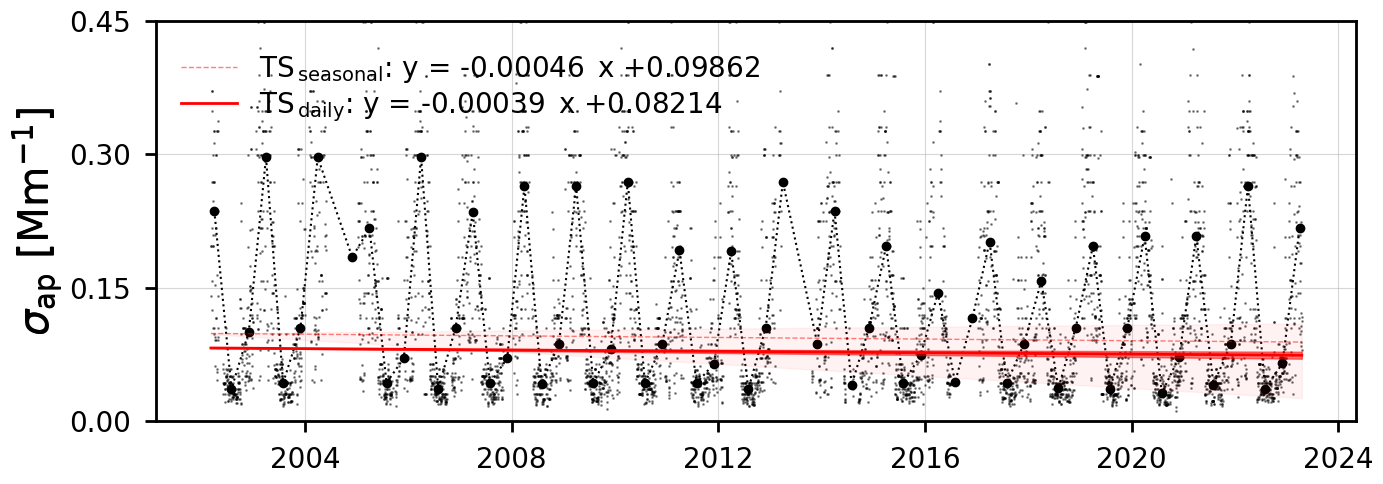

In [90]:
df_seasons = seasonal_averages(df_altered_clusters_seasons, var='abs_dependent_on_precip')

fig = full_plot(df_altered_clusters_seasons, df_seasons, var='abs_dependent_on_precip', season='all_seasons',
                ylabel=ylabel, units=units, dict_season_to_color=dict_season_to_color,
                dict_season_to_ylim=dict_season_to_ylim, ymax2=20, show_trend=True, show_points=True)

## no plot: just the calculations, do not show the plots: 

In [98]:
def errorbar_values(df_groupby, idx=None, add_interpolate=False,):                  
    df_groupby = df_groupby.set_index('bin_centres')
    df_groupby.index = df_groupby.index.astype(float) #if bins of 1 
    df_groupby = df_groupby[~df_groupby.isin([np.inf, -np.inf]).any(1)]
    index = df_groupby.index
    median = df_groupby['median']
    mean = df_groupby['mean']
    count = df_groupby['count']    
    quan_25 = df_groupby['q25'].values
    quan_75 = df_groupby['q75'].values
    
    if idx is not None:        
        slope, intercept = calculate_slope_intercept(index, median, idx)
        slope3sf = significant_figures(slope, 3)
        
    if add_interpolate == True:
        x = list(df_groupby.index)
        y = df_groupby['median'].values
        try:
            f = interp1d(x, y)
            xnew = np.linspace(x[0], x[-1], num=41, endpoint=True)
            ax.plot(xnew, f(xnew), marker='*',lw=0, label='linear inter.')
            interpolated_acc = xnew
            interpolated_obs = f(xnew)
        except:
            interpolated_acc = None
            interpolated_obs = None
            pass

    if add_interpolate==True:
        return interpolated_acc, interpolated_obs

def produce_dict_precip_abs_no_plot(df, startyear=2002, endyear=2023, season=None, cluster=None,
                            bins=None, threshold=0, add_interpolate=True):    
    if bins is None:
        bins = np.arange(0,20, 0.25)    
    if season is not None:
        df = df[df['season_abb'] == season].copy()
        title="Season: "+str(season)
    if cluster is not None:
        title="Cluster: "+str(cluster)  
    if (cluster is not None) & (season is not None):
        title="Cluster: "+str(cluster)+" Season: "+str(season)  
    
    df_year = fu_trends.slice_df(df, start_datetime=str(startyear)+'-01-01', end_datetime=str(endyear)+'-12-31')    
    
    df_binned = fu_trends.bin_data(df_year, number_of_bins=bins)
    df_groupby = fu_trends.produce_groupby_averages(df_binned)
    df_groupby = df_groupby.copy()         
    df_groupby = df_groupby.loc[(df_groupby['count'] > threshold)]

    max_value = df_groupby[['mean','median', 'min', 'max', 'std', 'q25', 'q75']].max()
    
    if add_interpolate==False:
        precip_to_abs = dict(zip(df_groupby['bin_centres'], df_groupby['median']))
        
    if add_interpolate==True:
        interpolated_acc, interpolated_obs = errorbar_values(df_groupby, add_interpolate=add_interpolate)
        precip_to_abs = dict(zip(interpolated_acc, interpolated_obs))  
       
    return precip_to_abs

def dict_precip_to_abs_clusters_seasons_no_plot(df, bins, threshold):
    dict_precip_to_abs = {}
    for cluster in [1,2,3,4,5]:
        df_cluster = df[df['clusters_5'] == cluster].copy()
        for season in ['AHZ', 'SUM', 'SBU']:
            try:
                precip_to_abs = produce_dict_precip_abs_no_plot(df_cluster, bins=bins, threshold=threshold,
                                                        cluster=cluster, season=season,
                                                        add_interpolate=True)
                dict_precip_to_abs['cluster_'+str(cluster)+'_'+str(season)] = precip_to_abs
            except:
                pass
    return dict_precip_to_abs

def get_many_dicts(df_max_count_abs637, fraction=.5, bins=np.arange(0,50, 2), threshold=10,
                  show_plots=False):
    df = df_max_count_abs637.sample(frac=fraction)
    
    if show_plots == True:
        fig = produce_multiple_subplot(df, threshold=10, bins=np.arange(0,50, 2), clusters = [1,2,3,4,5], 
                                 seasons = ['AHZ', 'SUM', 'SBU'], fontsize=20, fs_ticks=12)
    
    clusters = [1,2,3,4,5]
    seasons = ['AHZ', 'SUM', 'SBU']
    number_of_plots = len(clusters)*len(seasons)
    nrows=len(clusters); ncols=len(seasons)
    dict_name_to_df, dict_name_to_len = get_df_dict(df, number_of_plots, threshold=threshold, bins=bins)
    dict_precip_to_abs = dict_precip_to_abs_clusters_seasons(df, threshold=threshold, bins=bins)
    return dict_precip_to_abs

def produce_seasonal_test_daily_no_plot(df_daily_abs, var='abs637', freq=365.25, sigfigs=5):    
    #turn to intergers
    df_daily_abs['day'] = df_daily_abs.index
    df_daily_abs['ordinal'] = df_daily_abs['day'].apply(lambda x: x.toordinal())
    df_daily_abs['ordinal'] = df_daily_abs['ordinal'] - df_daily_abs['ordinal'][0] + 1

    date_ints = list(df_daily_abs['ordinal'].values)
    
    x = np.array([x-date_ints[0]+1 for x in date_ints])    
    y = df_daily_abs[var].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m_sg=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    return theil_m

def get_trend_no_plot(df_max_count_abs637, fraction=.5, bins=np.arange(0,50, 2), threshold=10, 
                     calculate_mk=True, alpha_xhomo=0):
    dict_precip_to_abs = get_many_dicts(df_max_count_abs637, fraction=fraction,
                                       bins=bins, threshold=threshold)
    df_altered_clusters_seasons = create_composite_using_seasons_clusters(df_max_count_abs637, dict_precip_to_abs)
    df_altered_clusters_seasons = df_altered_clusters_seasons.set_index('index')
    
    df_altered_clusters_seasons = remove_unwanted_values(df_altered_clusters_seasons, var='abs_dependent_on_precip')
    df_altered_clusters_seasons_daily = daily_medians(df_altered_clusters_seasons, var='abs_dependent_on_precip')
    theil_m = produce_seasonal_test_daily_no_plot(df_altered_clusters_seasons_daily, var='abs_dependent_on_precip',  
                                                 freq=365.25, sigfigs=5)
    
    print("trend (no prewhitened):")
    print(theil_m)
    
    ###mk trend#############
    if calculate_mk == True:
        print("slope cal: ")
        df_daily_ = fu_trends.add_seasons_to_daily(df_altered_clusters_seasons_daily)
        dict_season_to_df =  fu_trends.get_dict_of_season_dfs(df_daily_)
        out =  fu_trends.get_seasonal_trend_output(dict_season_to_df, var=var, alpha_xhomo=alpha_xhomo)
        df_stats_table =  fu_trends.produce_table(out)
        season = 'combined'
        slope_cal = float(df_stats_table.loc[season]['slope'])
        print(slope_cal)
        p = float(df_stats_table.loc[season]['p'])
        ss = float(df_stats_table.loc[season]['ss'])
        slope_info = (slope_cal, p, ss)
    ########################
    
    if calculate_mk == True:
        return theil_m, slope_info
    if calculate_mk == False:
        return theil_m

def trends_per_fraction_no_plot(df, number=50, fraction=.5, 
                        bins=np.arange(0,50, 2), threshold=10, calculate_mk=True, alpha_xhomo=0):
    trends = []
    pw_trends = []
    for i in tqdm(np.arange(1, number+1, 1)):
        print("number: "+str(i))
        if calculate_mk==True:
            theil_m, slope_info = get_trend_no_plot(df, fraction=fraction,
                                bins=bins, threshold=threshold, calculate_mk=True,
                                                   alpha_xhomo=alpha_xhomo)
        if calculate_mk==False:
            theil_m = get_trend_no_plot(df, fraction=fraction,
                                bins=bins, threshold=threshold, calculate_mk=False,
                                       alpha_xhomo=alpha_xhomo)
        
        trends.append(theil_m)
        pw_trends.append(slope_info)
    if calculate_mk == False:
        return trends
    if calculate_mk == True:
        return trends, pw_trends

In [99]:
def get_trend(df_max_count_abs637, fraction=.5, bins=np.arange(0,50, 2), threshold=10):
    dict_precip_to_abs = get_many_dicts(df_max_count_abs637, fraction=fraction,
                                       bins=bins, threshold=threshold)
    df_altered_clusters_seasons = create_composite_using_seasons_clusters(df_max_count_abs637, dict_precip_to_abs)
    df_altered_clusters_seasons = df_altered_clusters_seasons.set_index('index')

    fig, ax = plt.subplots(figsize=(10,4))

    df_altered_clusters_seasons = remove_unwanted_values(df_altered_clusters_seasons, var='abs_dependent_on_precip')
    df_altered_clusters_seasons_daily = daily_medians(df_altered_clusters_seasons, var='abs_dependent_on_precip')
    
    ax.plot(df_altered_clusters_seasons_daily.index, df_altered_clusters_seasons_daily['abs_dependent_on_precip'].values, 'o', 
            c='k', ms=1, alpha=0.4)

    ax, theil_m = produce_seasonal_test_daily_ax(df_altered_clusters_seasons_daily, var='abs_dependent_on_precip',  
                                                 fs_legend=10, ms=5, freq=365.25, sigfigs=5, 
                                                 linecolour = 'red', 
                   ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label = 30, 
                   xcoord_legend=-0.1, ycoord_legend=1.15, mscale = 2, ymin=-0.1, ymax = 2, ax=ax)
    ax.set_ylim(-0, 0.8)
    plt.show()
    return theil_m

def trends_per_fraction(df, number=50, fraction=.5, 
                        bins=np.arange(0,50, 2), threshold=10):
    trends = []
    for i in np.arange(1, number+1, 1):
        theil_m = get_trend(df, fraction=fraction,
                            bins=bins, threshold=threshold)
        trends.append(theil_m)
    return trends

In [84]:
def save_array(arr, name, trend_arrays_path=r'C:\Users\DominicHeslinRees\Documents\Analysis\trends_cal_abs'):
    print(trend_arrays_path+'\\'+name+'.txt')
    np.savetxt(fname=trend_arrays_path+'\\'+name+'.txt', X=arr)

# Individual analysis for bins, and fractions

Perform the analysis of calculating the estimated "modelled" trend, varying the number of bins, threshold and number of times

all the data used i.e. 100%

In [ ]:
trends_100percentage_1bin_threshold10, pw_trends_100percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                        number=1, fraction=1.0, 
                        bins=np.arange(0,50, 1), threshold=10)
save_array(trends_100percentage_1bin_threshold10, name='trends_100percentage_1bin_threshold10')
save_array(pw_trends_100percentage_1bin_threshold10, name='pw_trends_100percentage_1bin_threshold10')

2 mmm bins instead of 1 mm bins

In [ ]:
trends_100percentage_2bin_threshold10, pw_trends_100percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                        number=1, fraction=1.0, 
                        bins=np.arange(0,50, 2), threshold=10)
save_array(trends_100percentage_2bin_threshold10, name='trends_100percentage_2bin_threshold10')
save_array(pw_trends_100percentage_2bin_threshold10, name='pw_trends_100percentage_2bin_threshold10')

50 percentage of the bin

In [ ]:
trends_50percentage_2bin_threshold10, pw_trends_50percentage_2bin_threshold10,  = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                    number=50, fraction=.5, 
                                                                                                    bins=np.arange(0,50, 2), 
                                                                                                    threshold=10, alpha_xhomo=0)
save_array(trends_50percentage_2bin_threshold10, 'trends_50percentage_2bin_threshold10')
save_array(pw_trends_50percentage_2bin_threshold10, 'pw_trends_50percentage_2bin_threshold10')

In [ ]:
trends_50percentage_1bin_threshold10, pw_trends_50percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, number=50, fraction=.5, 
                        bins=np.arange(0,50, 1), threshold=10)
save_array(trends_50percentage_1bin_threshold10, 'trends_50percentage_1bin_threshold10')
save_array(pw_trends_50percentage_1bin_threshold10, 'trends_50percentage_1bin_threshold10')

40 percentage of the data is used 

In [ ]:
trends_40percentage_2bin_threshold10, pw_trends_40percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, number=50, 
                                                                                                            fraction=.4, 
                                                                                                            bins=np.arange(0,50, 2), 
                                                                                                            threshold=10)
save_array(trends_40percentage_2bin_threshold10, 'trends_40percentage_2bin_threshold10')
save_array(pw_trends_40percentage_2bin_threshold10, 'pw_trends_40percentage_2bin_threshold10')

In [ ]:
trends_40percentage_1bin_threshold10, pw_trends_40percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                    number=50, fraction=.4, 
                                                                                                    bins=np.arange(0,50, 1), threshold=10)
save_array(trends_40percentage_1bin_threshold10, 'trends_40percentage_1bin_threshold10')
save_array(pw_trends_40percentage_1bin_threshold10, 'pw_trends_40percentage_1bin_threshold10')

In [96]:
print(np.mean(trends_40percentage_1bin_threshold10))

-0.00034288065898032555
0.0


30 percentage of data used 

In [ ]:
trends_30percentage_2bin_threshold10, pw_trends_30percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                            number=50, fraction=.3, 
                                                        bins=np.arange(0,50, 2), threshold=10)
save_array(trends_30percentage_2bin_threshold10, 'trends_30percentage_2bin_threshold10')
save_array(pw_trends_30percentage_2bin_threshold10, 'pw_trends_30percentage_2bin_threshold10')

In [98]:
np.mean(trends_30percentage_2bin_threshold10)

-0.0004236146907216485

In [ ]:
trends_30percentage_1bin_threshold10, pw_trends_30percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, number=50, fraction=.3, 
                        bins=np.arange(0,50, 1), threshold=10)
save_array(trends_30percentage_1bin_threshold10, 'trends_30percentage_1bin_threshold10')
save_array(pw_trends_30percentage_1bin_threshold10, 'pw_trends_30percentage_1bin_threshold10')

# Figure 7:

Load the pre-saved arrays that have been performed for the paper: 

In [4]:
load_path_arrays = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\trends_cal_abs'

pw_trends_100percentage_1bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_100percentage_1bin_threshold10'+'.txt')
pw_trends_100percentage_2bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_100percentage_2bin_threshold10'+'.txt')
pw_trends_50percentage_2bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_50percentage_2bin_threshold10'+'.txt')
pw_trends_50percentage_1bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_50percentage_1bin_threshold10'+'.txt')
pw_trends_40percentage_1bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_40percentage_1bin_threshold10'+'.txt')
pw_trends_40percentage_2bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_40percentage_2bin_threshold10'+'.txt')
pw_trends_30percentage_1bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_30percentage_1bin_threshold10'+'.txt')
pw_trends_30percentage_2bin_threshold10 = np.loadtxt(load_path_arrays+'\\'+'pw_trends_30percentage_2bin_threshold10'+'.txt')

In [5]:
pw_trends_40percentage_1bin_threshold10 = pw_trends_40percentage_1bin_threshold10.tolist()

In [10]:
trend_infos = [pw_trends_50percentage_2bin_threshold10,
               pw_trends_50percentage_1bin_threshold10,
               pw_trends_40percentage_2bin_threshold10,
               pw_trends_40percentage_1bin_threshold10,
               pw_trends_30percentage_2bin_threshold10,
               pw_trends_30percentage_1bin_threshold10]

trends = []
for i in trend_infos:
    trend = i[0][0]
    trends.append(trend)

In [6]:
def get_all_trends_from_list(list_of_trend_info):
    trends = []
    for i in list_of_trend_info:
        trend = i[0]
        trends.append(trend)
    return trends

In [7]:
def get_data_list(trend_infos):
    data = []
    for trend_info in trend_infos:
        trends = get_all_trends_from_list(trend_info)
        data.append(trends)
    return data

In [8]:
def boxplot(data, trends_100percentage_1bin, trends_100percentage_2bin,
            trend_abs=-0.0022087046467218333, xticklabels=['0.5', '0.5','0.4', '0.4', '0.3', '0.3'],
            ymin=-0.0025, ymax=0.0002, pw_trends_mean=None):
    fig, ax = plt.subplots(figsize=(8,5))
    bp = ax.boxplot(data, notch=False, sym='+', vert=True, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    box_colors = ['darkkhaki', 'royalblue']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2], alpha=.5))

        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]

    pos = np.arange(num_boxes) + 1
    upper_labels = [str(round(s, 5)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax.get_xticklabels()):
        print(label)
        print(upper_labels[tick])
        k = tick % 2
        ax.text(pos[tick], .95, upper_labels[tick],
                 transform=ax.get_xaxis_transform(),
                 horizontalalignment='center', size='x-small',
                 weight=weights[k], color=box_colors[k])

    for median in bp['medians']:
        median.set_color('black')

    ax.axhline(trends_100percentage_2bin, c=box_colors[0], ls=':')
    ax.axhline(trends_100percentage_1bin, c=box_colors[1], ls=':')

    ax.axhline(trend_abs, c='r')
    if pw_trends_mean is not None:
        ax.axhline(pw_trends_mean, c='k', ls=':')

    ax.set_ylim(ymin, ymax) #trend
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Fraction of the data used as sample subset [-]', fontsize=20)
    ax.set_ylabel('Trend in $\sigma_{\mathrm{cal. ap}}$ [Mm$^{-1}$yr$^{-1}$]', fontsize=20)

    darkkhaki_patch = mpatches.Patch(color=box_colors[0], label='2mm bins')
    royalblue_patch = mpatches.Patch(color=box_colors[1], label='1mm bins')
    
    red_line = mlines.Line2D([], [], color='r',
                          label='obs. trend')
    darkkhaki_line = mlines.Line2D([], [], color=box_colors[0],
                          label='trend in $\sigma_{\mathrm{cal. ap}}$\n(all data used)')
    royalblue_line = mlines.Line2D([], [], color=box_colors[1],
                          label='trend in $\sigma_{\mathrm{cal. ap}}$\n(all data used)')

    plt.legend(handles=[darkkhaki_patch, royalblue_patch, red_line, darkkhaki_line, royalblue_line], fontsize=12,
              bbox_to_anchor=(1.04, 1), borderaxespad=0, frameon=False)

    fancy(ax)

    plt.show()
    return fig

In [11]:
data = get_data_list(trend_infos)

Text(0, 0, '')
-0.00022
Text(0, 0, '')
-0.00018
Text(0, 0, '')
-0.00018
Text(0, 0, '')
-0.00016
Text(0, 0, '')
-0.00026
Text(0, 0, '')
-0.00012


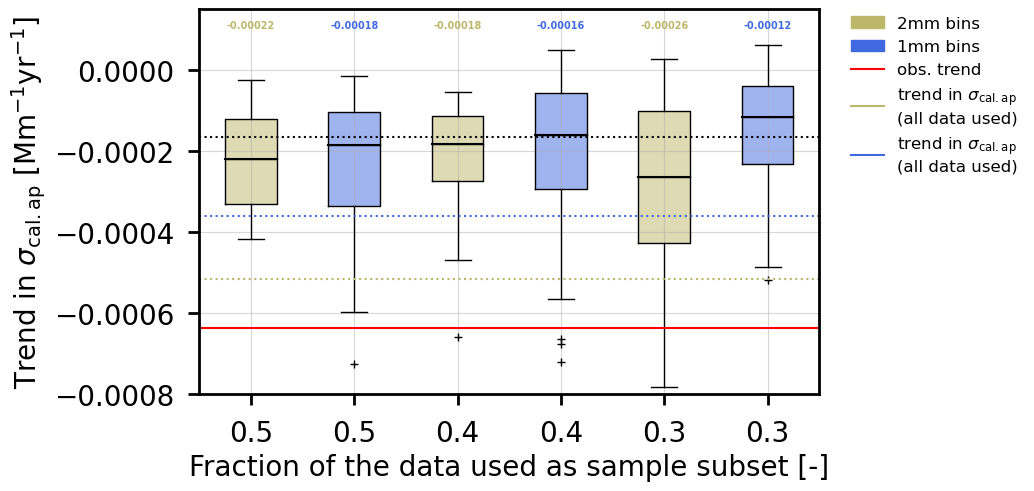

saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\Figure7.png


In [12]:
fig = boxplot(data, pw_trends_100percentage_2bin_threshold10[0], pw_trends_100percentage_1bin_threshold10[0],
            trend_abs=-0.0006366671673837635, xticklabels=['0.5', '0.5', '0.4', '0.4', '0.3', '0.3'], ymin=-0.0008, 
              ymax=0.00015, pw_trends_mean=-0.0001638067505532209)
fu_trends.save_plot(fig, savepath_plots, name='Figure7', formate='.png')

In [39]:
def average_trend(pw_trends_100percentage_2bin_threshold10, pw_trends_100percentage_1bin_threshold10, 
                 pw_trends_50percentage_1bin_threshold10, pw_trends_50percentage_2bin_threshold10,
                 pw_trends_40percentage_1bin_threshold10, pw_trends_40percentage_2bin_threshold10,
                 pw_trends_30percentage_1bin_threshold10, pw_trends_30percentage_2bin_threshold10):
    pw_trends_100 = np.float(pw_trends_100percentage_2bin_threshold10[0]) + np.float(pw_trends_100percentage_1bin_threshold10[0])
    pw_trends_50 = np.mean(get_all_trends_from_list(pw_trends_50percentage_1bin_threshold10)) + np.mean(get_all_trends_from_list(pw_trends_50percentage_2bin_threshold10))
    pw_trends_40 = np.mean(get_all_trends_from_list(pw_trends_40percentage_1bin_threshold10)) + np.mean(get_all_trends_from_list(pw_trends_40percentage_2bin_threshold10))
    pw_trends_30 = np.mean(get_all_trends_from_list(pw_trends_30percentage_1bin_threshold10)) + np.mean(get_all_trends_from_list(pw_trends_30percentage_2bin_threshold10))

    pw_trends = (pw_trends_50 + pw_trends_40 + pw_trends_30)/8

    print(pw_trends_100, pw_trends_50, pw_trends_40, pw_trends_30)

    print(pw_trends)
    return pw_trends

In [40]:
pw_trends = average_trend(pw_trends_100percentage_2bin_threshold10, pw_trends_100percentage_1bin_threshold10, 
                 pw_trends_50percentage_1bin_threshold10, pw_trends_50percentage_2bin_threshold10,
                 pw_trends_40percentage_1bin_threshold10, pw_trends_40percentage_2bin_threshold10,
                 pw_trends_30percentage_1bin_threshold10, pw_trends_30percentage_2bin_threshold10)

-0.0008742873460397464 -0.00046555653126752487 -0.0004085292423095571 -0.00043636823084868524
-0.0001638067505532209


<ipython-input-39-eefacc0ef3d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pw_trends_100 = np.float(pw_trends_100percentage_2bin_threshold10[0]) + np.float(pw_trends_100percentage_1bin_threshold10[0])


In [41]:
trend_abs=-0.0006366671673837635
pw_trends=-0.0001638067505532209
print(pw_trends/trend_abs)

0.2572878875258275


In [ ]:
trends_100 = np.float(trends_100percentage_2bin_threshold10[0]) + np.float(trends_100percentage_1bin_threshold10[0])
trends_50 = np.mean(trends_50percentage_1bin_threshold10) + np.mean(trends_50percentage_2bin_threshold10)
trends_40 = np.mean(trends_40percentage_1bin_threshold10) + np.mean(trends_40percentage_2bin_threshold10)
trends_30 = np.mean(trends_30percentage_1bin_threshold10) + np.mean(trends_30percentage_2bin_threshold10)

trends = (trends_100 + trends_50 + trends_40 + trends_30)/8
print(trends)

In [105]:
trends_100percentage_2bin_threshold10

[-0.0005840040650406504]

In [106]:
np.mean(trends_50percentage_1bin_threshold10) + np.mean(trends_50percentage_2bin_threshold10) 

-0.0008858385931900163

# Perform the analysis and save the arrays: 

In [290]:
def complete_all_analysis(df_max_count_abs637, number=50, threshold=10):
    #allways the same with 100 percen
    trends_100percentage_1bin_threshold10, pw_trends_100percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                            number=1, fraction=1.0, 
                            bins=np.arange(0,50, 1), threshold=threshold)
    save_array(trends_100percentage_1bin_threshold10, name='trends_100percentage_1bin_threshold10')
    save_array(pw_trends_100percentage_1bin_threshold10, name='pw_trends_100percentage_1bin_threshold10')

    trends_100percentage_2bin_threshold10, pw_trends_100percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                            number=1, fraction=1.0, 
                            bins=np.arange(0,50, 2), threshold=threshold)
    save_array(trends_100percentage_2bin_threshold10, name='trends_100percentage_2bin_threshold10')
    save_array(pw_trends_100percentage_2bin_threshold10, name='pw_trends_100percentage_2bin_threshold10')

    #50 percent
    trends_50percentage_1bin_threshold10, pw_trends_50percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, number=number, 
                                                                                                                fraction=.5, 
                                                                                                                bins=np.arange(0,50, 1), threshold=threshold)
    save_array(trends_50percentage_1bin_threshold10, 'trends_50percentage_1bin_threshold10')
    save_array(pw_trends_50percentage_1bin_threshold10, 'pw_trends_50percentage_1bin_threshold10')

    trends_50percentage_2bin_threshold10, pw_trends_50percentage_2bin_threshold10,  = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                        number=number, fraction=.5, 
                                                                                                        bins=np.arange(0,50, 2), 
                                                                                                        threshold=threshold, alpha_xhomo=0)
    save_array(trends_50percentage_2bin_threshold10, 'trends_50percentage_2bin_threshold10')
    save_array(pw_trends_50percentage_2bin_threshold10, 'pw_trends_50percentage_2bin_threshold10')

    #40 percent
    trends_40percentage_1bin_threshold10, pw_trends_40percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                        number=number, fraction=.4, 
                                                                                                        bins=np.arange(0,50, 1), threshold=threshold)
    save_array(trends_40percentage_1bin_threshold10, 'trends_40percentage_1bin_threshold10')
    save_array(pw_trends_40percentage_1bin_threshold10, 'pw_trends_40percentage_1bin_threshold10')

    trends_40percentage_2bin_threshold10, pw_trends_40percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, number=number, 
                                                                                                                fraction=.4, 
                                                                                                                bins=np.arange(0,50, 2), 
                                                                                                                threshold=threshold)
    save_array(trends_40percentage_2bin_threshold10, 'trends_40percentage_2bin_threshold10')
    save_array(pw_trends_40percentage_2bin_threshold10, 'pw_trends_40percentage_2bin_threshold10')

    #30 percent
    trends_30percentage_1bin_threshold10, pw_trends_30percentage_1bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                                number=number, fraction=.3, 
                                                                                                                bins=np.arange(0,50, 1), threshold=threshold)
    save_array(trends_30percentage_1bin_threshold10, 'trends_30percentage_1bin_threshold10')
    save_array(pw_trends_30percentage_1bin_threshold10, 'pw_trends_30percentage_1bin_threshold10')

    trends_30percentage_2bin_threshold10, pw_trends_30percentage_2bin_threshold10 = trends_per_fraction_no_plot(df_max_count_abs637, 
                                                                                                                number=number, fraction=.3, 
                                                                                                                bins=np.arange(0,50, 2), threshold=threshold)
    save_array(trends_30percentage_2bin_threshold10, 'trends_30percentage_2bin_threshold10')
    save_array(pw_trends_30percentage_2bin_threshold10, 'pw_trends_30percentage_2bin_threshold10')

In [ ]:
complete_all_analysis(df_max_count_abs637, number=50, threshold=10)

# Stats table for the estimated absorption coefficient: 

Here, we analysis the dataframe for the estimated absorption cofficients

In [107]:
month_to_season =  { 1:'SBU',  2:'AHZ', 3:'AHZ',  
                     4:'AHZ',  5:'AHZ', 6:'SUM',  7:'SUM',  8:'SUM', 9:'SUM', 10:'SBU', 
                     11:'SBU', 12:'SBU'}  

df_altered_clusters_seasons = remove_unwanted_values(df_altered_clusters_seasons, var='abs_dependent_on_precip')
df_days = daily_medians(df_altered_clusters_seasons, var='abs_dependent_on_precip')

df_days.loc[:,'month_num'] = df_days.index.month
df_days.loc[:,'year'] = df_days.index.year        
df_days.loc[:,'season'] = df_days.month_num.map(month_to_season).values

In [108]:
def get_dict_of_season_dfs(df):
    df = df.copy()
    if 'season' not in df.columns:
        df['season'] = df['season_abb_year'].apply(lambda x: str(x)[:3])
    df_AHZ = df[df['season'] == 'AHZ']
    df_SUM = df[df['season'] == 'SUM']
    df_SBU = df[df['season'] == 'SBU']
    dict_season_to_df = {'AHZ':df_AHZ, 'SUM':df_SUM, 'SBU':df_SBU}
    return dict_season_to_df

def convert_to_datetime(x):
    x_datetime = datetime(pd.to_datetime(x).year, pd.to_datetime(x).month, pd.to_datetime(x).day)
    return x_datetime

def produce_table(out):
    parameters = ['p', 'ss', 'slope', 'ucl', 'lcl']
    print(parameters)
    df_stats_table = pd.DataFrame(columns=parameters, dtype=np.float64)
    seasons = ['AHZ', 'SBU', 'SUM', 'combined']
    for season_n, season_name in enumerate(seasons):
        print(season_name)
        for parameter in parameters:
            print(out[season_n][parameter])
            df_stats_table.loc[season_name, parameter] = out[season_n][parameter]
    return df_stats_table

In [109]:
dict_season_to_df = get_dict_of_season_dfs(df_days)

In [110]:
var = 'abs_dependent_on_precip'

df_AHZ, df_SUM, df_SBU = [*dict_season_to_df.values()][0], [*dict_season_to_df.values()][1], [*dict_season_to_df.values()][2]
multi_obs = [df_AHZ[var].values, df_SUM[var].values, df_SBU[var].values]
multi_obs_dts = [np.array([convert_to_datetime(x) for x in df_AHZ.index]),
                 np.array([convert_to_datetime(x) for x in df_SUM.index]), 
                 np.array([convert_to_datetime(x) for x in df_SBU.index])]
# Process it
out = mk.mk_temp_aggr(multi_obs_dts, multi_obs, 0.002, pw_method='3pw', alpha_xhomo=80)

n_season = 3
# Print the results
for n in range(n_season):
    print('Season {ind}:'.format(ind=n+1), out[n])
print('Combined yearly trend:', out[n_season])

Season 1: {'p': 0.21760999577718376, 'ss': -1, 'slope': -0.0009504650954225107, 'ucl': 5.9788487355217364e-05, 'lcl': -0.002357636956481324}
Season 2: {'p': 0.13624620562694134, 'ss': -1, 'slope': -7.11045611800556e-05, 'ucl': 5.7081837606424125e-05, 'lcl': -0.00022216951851780848}
Season 3: {'p': 0.28470661078897486, 'ss': -1, 'slope': -0.0002436949892523235, 'ucl': 0.00018473120982437328, 'lcl': -0.0007977307532824481}
Combined yearly trend: {'p': 0.028201532609926305, 'ss': 95, 'slope': -0.0002436949892523235, 'ucl': 5.9788487355217364e-05, 'lcl': -0.0007977307532824481}


In [111]:
df_stats_table_days = produce_table(out)

['p', 'ss', 'slope', 'ucl', 'lcl']
AHZ
0.21760999577718376
-1
-0.0009504650954225107
5.9788487355217364e-05
-0.002357636956481324
SBU
0.13624620562694134
-1
-7.11045611800556e-05
5.7081837606424125e-05
-0.00022216951851780848
SUM
0.28470661078897486
-1
-0.0002436949892523235
0.00018473120982437328
-0.0007977307532824481
combined
0.028201532609926305
95
-0.0002436949892523235
5.9788487355217364e-05
-0.0007977307532824481


In [112]:
df_stats_table_days

,p,ss,slope,ucl,lcl
AHZ,0.217610,-1.0,-0.000950,0.000060,-0.002358
SBU,0.136246,-1.0,-0.000071,0.000057,-0.000222
SUM,0.284707,-1.0,-0.000244,0.000185,-0.000798
combined,0.028202,95.0,-0.000244,0.000060,-0.000798
